In [1]:
import numpy as np
import math
import networkx as nx
from scipy.stats import truncnorm
import scipy.io
from scipy import sparse
import matplotlib.pyplot as plt
from shapely.geometry import *
import geopandas as gpd
import pandas as pd

In [2]:
  #normalize edge weights for viweing with networkx graph
def standardWidth(G):
    EdgeWeights = [x[2] for x in list(G.edges(data = 'weight'))]
    StandardEdgeWeights = (EdgeWeights - np.mean(EdgeWeights)) / np.std(EdgeWeights)
    return StandardEdgeWeights

In [3]:
#view Empirical networks
def drawMatNetworks( filename):
    print("fungal network:", filename)
    matC = scipy.io.loadmat('fungal_MATLAB\Conductance' +filename)
    positionsC = dict()
    for i in range(len(matC['coordinates'])):
        positionsC[i] = (matC['coordinates'][i][0],matC['coordinates'][i][1])
    GC = nx.from_numpy_matrix(sparse.csc_matrix(matC['A']).todense(), parallel_edges = False)
    nx.set_node_attributes(GC, positionsC, 'coord')
    posC = matC['coordinates']
    #normalize edge weights for viweing
    StandardEdgeWeightsC = standardWidth(GC) + 0.5
    print("Conductance")
    nx.draw(GC, pos =posC, width = StandardEdgeWeightsC, node_size = 0.2)
    plt.show()

    matP = scipy.io.loadmat('fungal_MATLAB\PathScore' +filename )
    positionsP = dict()
    for i in range(len(matP['coordinates'])):
        positionsP[i] = (matP['coordinates'][i][0],matP['coordinates'][i][1])
    GP = nx.from_numpy_matrix(sparse.csc_matrix(matP['A']).todense(), parallel_edges = False)
    nx.set_node_attributes(GP, positionsP, 'coord')
    posP = matP['coordinates']
    #normalize edge weights for viweing
    StandardEdgeWeightsP = standardWidth(GP) + 0.5
    print("Path Score:", )
    nx.draw(GP, pos =posP, width= StandardEdgeWeightsP, node_size = 0.2)
    plt.show()

fungal network: \Pv_M_I+4R_U_N_19d_2
Conductance


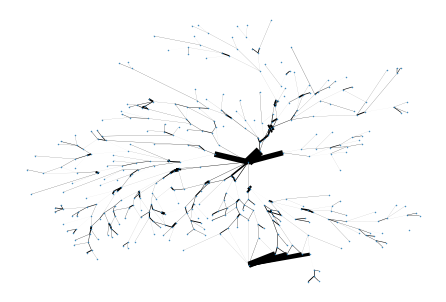

Path Score:


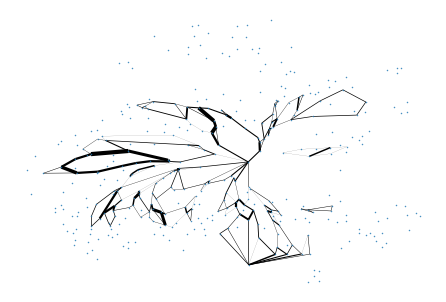

fungal network: \Pv_M_I+4R_U_N_32d_2
Conductance


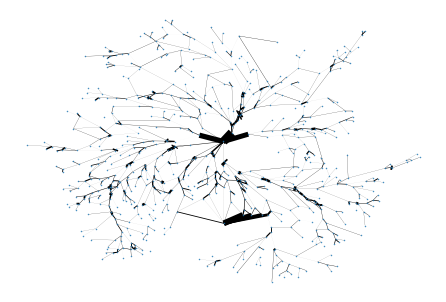

Path Score:


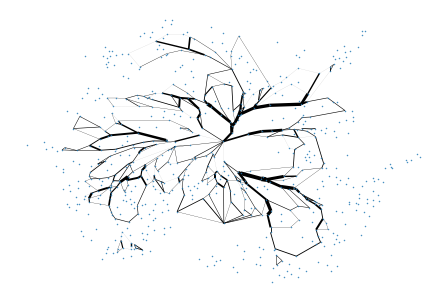

fungal network: \Pv_M_I+4R_U_N_50d_2
Conductance


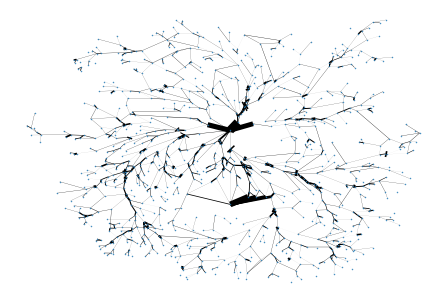

Path Score:


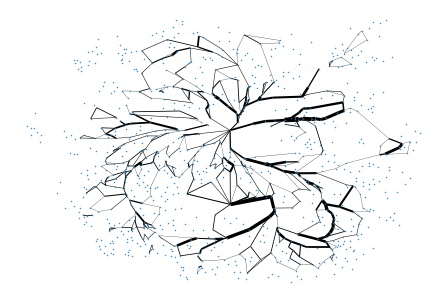

fungal network: \Pv_M_5xI_U_N_18d_1
Conductance


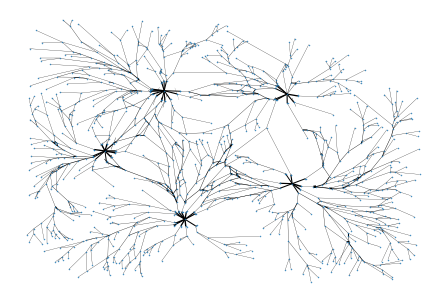

Path Score:


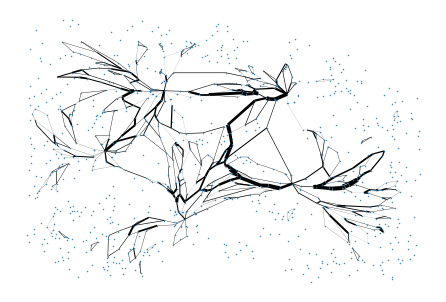

fungal network: \Pv_M_5xI_U_N_25d_1
Conductance


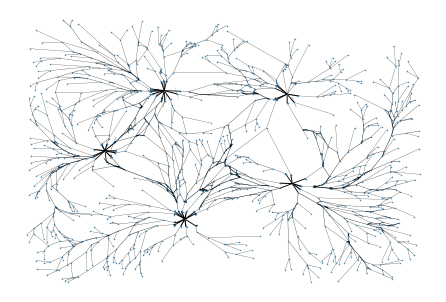

Path Score:


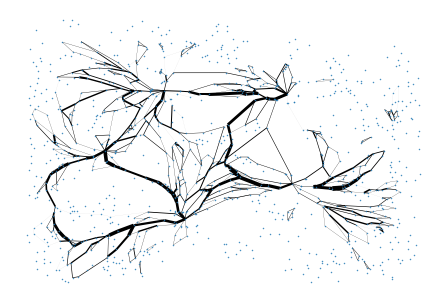

fungal network: \Pv_M_5xI_U_N_35d_1
Conductance


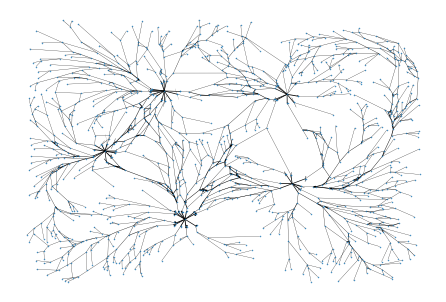

Path Score:


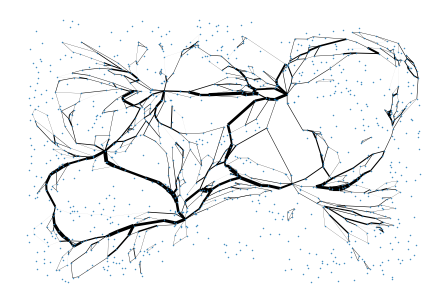

In [4]:

drawMatNetworks('\Pv_M_I+4R_U_N_19d_2')
drawMatNetworks('\Pv_M_I+4R_U_N_32d_2')
drawMatNetworks('\Pv_M_I+4R_U_N_50d_2')

drawMatNetworks('\Pv_M_5xI_U_N_18d_1')
drawMatNetworks('\Pv_M_5xI_U_N_25d_1')
drawMatNetworks('\Pv_M_5xI_U_N_35d_1')


fungal network: \Pp_M_Tokyo_U_N_26h_4
Conductance


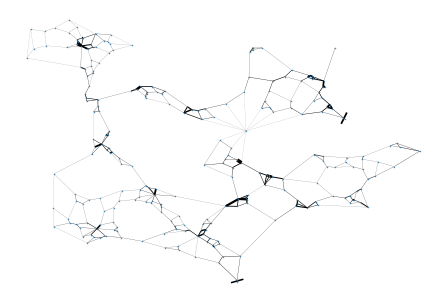

Path Score:


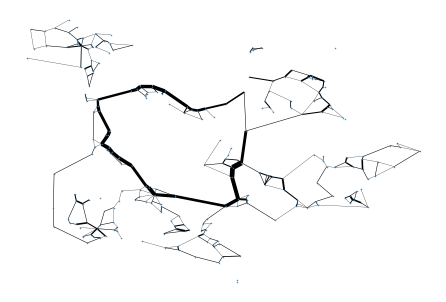

In [5]:
drawMatNetworks('\Pp_M_Tokyo_U_N_26h_4')

In [6]:
#foodMap is a MultiPolygon shapely type object
#coordinate is (x,y) tuple
#returns boolean
def hasFood(coordinate, foodMap):
    return foodMap.intersects(Point(coordinate))
    

In [7]:
def ranged_normal(mean, sd, low, upp):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(1)

In [8]:
def edgeLength(coord1, coord2)->float:
    return math.sqrt((coord1[0]-coord2[0])**2 + (coord1[1]-coord2[1])**2)

In [309]:
#coordinate = tuple, food = num
#returns new node coordinates, weight, length, food used
def hyphalGrowth(coordinates,food):
    if(food < 0.4):
        MaxL = 2
    else:
        MaxL = food#ADJUST VALUE for maximum length relative to food
    x = coordinates[0]
    y = coordinates[1]
    #creates bimodal distribution \/
    xn = x + (np.random.choice([-1,1], size = 1)*ranged_normal(1, 0.7, 0.2, MaxL))[0]
    #ajust values for mean hyphal growth length
    yn = y + (np.random.choice([-1,1], size = 1)*ranged_normal(1, 0.7, 0.2, MaxL))[0]
    coord2 = (xn,yn)
    Elength = edgeLength(coordinates, coord2)
    assert(Elength != 0)
    MaxW = food/Elength
    if(MaxW <= 0.3):#prevents infinite edges added
        weight = MaxW
    else:
        weight = ranged_normal(MaxW/2, 0.3, 0.1, MaxW)[0]#min val=> still okay to add small edges
    foodN = food - (Elength*weight)
    assert(weight > 0)
    return (coord2, weight, Elength, foodN)

In [420]:
#evenly distributes resources to edges proportional to edge weights
def porpEdgeGrowth(G, edgeNum,  food, edgeWSum):
    if( food < 0.2):
        G.edges[edgeNum]['weight'] = float((food/ G.edges[edgeNum]['length']) + G.edges[edgeNum]['weight'])
        assert(G.edges[edgeNum]['weight'] > 0)
        return 0
    else:
        assert(food >0)
        MaxW = (food/G.edges[edgeNum]['length'])
        assert(MaxW >0)
        p = (G.edges[edgeNum]['weight']/edgeWSum)* MaxW
        Wadd = ranged_normal(p, 0.2, 0, MaxW)[0]
        G.edges[edgeNum]['weight'] = Wadd + G.edges[edgeNum]['weight']
        assert(G.edges[edgeNum]['weight'] > 0)
        return food - Wadd*G.edges[edgeNum]['length']
        

In [103]:
#given a graph and a specific edge number returns availabel food resources to be transfered. 
#transfer amount is porportional to the current edge weight divided by sum of neighbor edge weights 
def ResourceTransferAmount(G, Edge):
    Available = G.edges[Edge]['weight'] * G.edges[Edge]['length']
    SumNeighborWeights = sum([x[2] for x in list(G.edges(Edge[0], data = 'weight'))]) + sum([x[2] for x in list(G.edges(Edge[1], data = 'weight'))]) - G.edges[Edge]['weight'] 
    transfer =(Available*(G.edges[Edge]['weight']/SumNeighborWeights))
    #transfer
    G.edges[Edge]['weight'] = ((Available - transfer)/G.edges[Edge]['length'])
    return transfer #units are Weight x Length

In [575]:
#Resolves all spatial intersections of edges in graph GS and returns new graph
#splits edge and distributes edge attributes, new edge is added to graph and old edges are removed
def ResolveIntersections(GS, nodeNum):
    
    GLines = []
    invertNodesDict = {v: k for k, v in dict(GS.nodes(data = 'coord')).items()}
    invertEdgeDict = {v: k for k, v in dict(GS.nodes(data = 'coord')).items()}
    #convert current graph to shapely edge lines
    GCoordList = list(dict(GS.nodes(data = 'coord')).values())
    for i  in GS.edges():
        GLines.append(LineString([(nx.get_node_attributes(GS, 'coord')[i[0]][0],nx.get_node_attributes(GS, 'coord')[i[0]][1]), 
                                  (nx.get_node_attributes(GS, 'coord')[i[1]][0],nx.get_node_attributes(GS, 'coord')[i[1]][1])  ]))

    IntersectLines = MultiLineString(GLines)
    for line in IntersectLines:
        IntersectionsMP = []
        #find intersections of each individual line
        NLines = gpd.GeoSeries(MultiLineString([i for i in GLines if i != line]))
        IntersectionsMP = NLines.unary_union.intersection(line)
        if(IntersectionsMP.is_empty):
            pass

        #coordinate list of intersection points
        if IntersectionsMP.geom_type == 'MultiPoint':
            InterCoords = [(p.x, p.y) for p in IntersectionsMP] #works for multiPoint
        elif IntersectionsMP.geom_type == 'Point':
            InterCoords = list(NLines.unary_union.intersection(line).coords)#works for point
        #resolve every intersection
        for point in InterCoords: #check if nodes already exist in networkx graph
            if(point not in GCoordList): #if node doesn't exist split line, find neighbor nodes, remove/add edges
                GCoordList += point #new point exists, prevents duplicates
                nodeNum = nodeNum +1
                GS.add_node(nodeNum, food = 0, coord=point) #add node to networkx
                #find all intersecting linestrings with new point
                for zine in IntersectLines:
                    if(zine.intersects(Point(point))):#lines to be split
                        nc1 = zine.coords[0] #endpoint of line/networkx node
                        n1 = invertNodesDict[nc1]#networkx node labels found
                        nc2 = zine.coords[1]
                        n2 = invertNodesDict[nc2]
                        Eattr = GS.edges[n1,n2] #get existing edge attributes
                        GS.add_edge(n1,nodeNum, Eattr)#create new edges
                        GS.edges[n1,nodeNum]['length'] = edgeLength(nc1, point)
                        GS.add_edge(n2,nodeNum, Eattr)
                        GS.edges[n2,nodeNum]['length'] = edgeLength(nc2, point)
                        GS.remove_edge(n1,n2)#remove existing edge
                        #don't really need to split in shapely so don't
    return nodeNum

In [ ]:
######TODO#############
#zipNodes and edges
#takes in Graph GS
#if two nodes are very close and connected by a short edge
#^(the 2 nodes connected to a very short edge)
#then place node between two existing nodes connect edges to new node, remove old nodes
#if this causes mulitedge then zip multi-edges attributes togethor


In [13]:
# G is graph with node attributes 'coord' and edge attribute 'weight'
#FoodMap is a Shapely multiPolygon containg polygons with food
def plotSim( G, FoodMap):
    for poly in FoodMap:
        plt.plot(*poly.exterior.xy, color = 'red')
    nx.draw(Gsim, pos =Gsim.nodes(data = 'coord'), width=standardWidth(Gsim) , node_size = 2)
    plt.show()

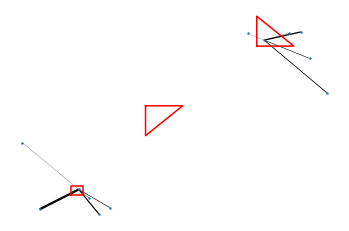

In [576]:
#############THIS IS THE MAIN WORKING SIMULATION#####(1/2)

# #initialize graph
Gsim = nx.Graph()
HarvestRate = 7 #ADJUST VALUE
nx.set_node_attributes(Gsim, 0 , 'food')
nx.set_node_attributes(Gsim, (0,0), 'coord')

nx.set_edge_attributes(Gsim, 0, 'flow')
nx.set_edge_attributes(Gsim, 0, 'resistance')
nx.set_edge_attributes(Gsim, 0, 'weight')
nx.set_edge_attributes(Gsim, 0, 'length')#technically dont need can be sourced from node data
nx.set_edge_attributes(Gsim, 0, '')

#set food sources map
f1 = Polygon([(0,0),(0,0.3),(0.3,0.3),(0.3,0)])
f2 = Polygon([(5,5),(5,6),(6,5)])
f3 = Polygon([(2,3),(2,2),(3,3)])
foodMap = MultiPolygon([f1,f2,f3])
#intial innoculation points
Gsim.add_node(0, food = HarvestRate, coord=(0.2,0.2))
Gsim.add_node(1, food = HarvestRate, coord=(5.2,5.2))
nodeNum = 1
# Gsim.add_node(2, food = HarvestRate, coord=(0.5,5.3))
# nodeNum = 2


#node iteration
tempGN = list(Gsim.nodes(data =True))#holds static for loop
for Nodes in tempGN:
    if( hasFood(Nodes[1]['coord'], foodMap)):
        Nodes[1]['food'] = HarvestRate
        #distribute food to immediately connected edges or add new edge
        #hyphal growth or distribute to edges??
       
        while(Nodes[1]['food'] > 0):#distribute all harvested food
            #coordinates, weight, length, food left
            NewGrowth = hyphalGrowth(Nodes[1]['coord'], Nodes[1]['food'] )
            nodeNum = nodeNum +1
            Gsim.add_node(nodeNum, food = 0, coord= NewGrowth[0])
            Gsim.add_edge(Nodes[0],nodeNum, weight = NewGrowth[1], length = NewGrowth[2], Rigidness = 0, PhaseRigid = 0, PhaseAbsFlow = 0, PrevPhFlow = NewGrowth[1]*NewGrowth[2])
            Nodes[1]['food'] = NewGrowth[3]

tempGE = list(Gsim.edges(data =True))
plotSim(Gsim, foodMap)

In [507]:
HarvestRate = 0.5

In [578]:
#############THIS IS THE MAIN WORKING SIMULATION#####(2/2)
####Executes single phase iteration for nodes and edges
##Repeat execution to run more phases
#decreasing harvest rate with fluctuation
HarvestRate = HarvestRate/2
if(HarvestRate < 0.2):
    HarvestRate = ranged_normal(0.2, 0.1, 0, 0.5)[0]
# iterate through nodes
tempGN = list(Gsim.nodes(data =True))#holds static for loop
for Nodes in tempGN:
    if( hasFood(Nodes[1]['coord'], foodMap)):#nodes only distribute resources if they are located over food sources
        Nodes[1]['food'] = HarvestRate
        #distribute food to immediately connected edges or add new edge
        #hyphal growth or distribute to edges??
        neighborWsum = sum([x[2] for x in list(Gsim.edges(Nodes[0], data = 'weight'))])
        hyphalFood = ranged_normal(0.2, 0.1, 0, 1)[0] * Nodes[1]['food']#ADJUST VALUE controls resource distribution to new edges or existing edges
        contFood = Nodes[1]['food'] - hyphalFood
        for kEdge in Gsim.edges(Nodes[0]):
            contFood = porpEdgeGrowth(Gsim, kEdge,  contFood, neighborWsum)
       
        Nodes[1]['food'] = hyphalFood
        while(Nodes[1]['food'] > 0.1):#ADJUST VALUE ,leftovers
            #coordinates, weight, length, food left
            NewGrowth = hyphalGrowth(Nodes[1]['coord'], Nodes[1]['food'] )
            nodeNum = nodeNum+1
            Gsim.add_node(nodeNum, food = 0, coord= NewGrowth[0])
            Gsim.add_edge(Nodes[0],nodeNum, weight = NewGrowth[1], length = NewGrowth[2], Rigidness = 0, PhaseRigid = 0, PhaseAbsFlow = 0, PrevPhFlow = NewGrowth[1]*NewGrowth[2])
            Nodes[1]['food'] = NewGrowth[3]
            
            
#iterate through edges
tempGE = list(Gsim.edges())
for Edgek in tempGE:
    #total resources capable of distributing
    transfer = ResourceTransferAmount(Gsim, Edgek)
    #TODO pressure causes hyphal growth vs. edge growth
    hyphalFood = ranged_normal(0.2, 0.05, 0, 0.4)[0] * transfer #add paramaters to distribution to affect hyphal growth/decay
    contFood = transfer - hyphalFood
    AllEdges = list(Gsim.edges(Edgek[0])) #TODO need to make asyncronous 
    AllEdges += list(Gsim.edges(Edgek[1]))
    neighborWsum = sum([Gsim.edges[x]['weight'] for x in AllEdges] ) #TODO make asychronous
    NWS = sum([x[2] for x in list(Gsim.edges(Edgek[0], data = 'weight'))]) + sum([x[2] for x in list(Gsim.edges(Edgek[1], data = 'weight'))])
    for kEdge in AllEdges :
            contFood = porpEdgeGrowth(Gsim, kEdge,  contFood, NWS)
    i = 0
    while(hyphalFood > 0.01):####VALUE TO ADJUST
        if(i == 0):#switch between which side the resources are being transfered to
            i = 1
        else:
            i = 0
        #TODO hyphal growth from edge midpoints instead
        
        #coordinates, weight, length, food left
        NewGrowth = hyphalGrowth(Gsim.nodes[Edgek[i]]['coord'], hyphalFood )
        nodeNum = nodeNum +1 
        Gsim.add_node(nodeNum, food = 0, coord= NewGrowth[0])
        Gsim.add_edge(Edgek[i],nodeNum, weight = NewGrowth[1], length = NewGrowth[2], Rigidness = 0, PhaseRigid = 0, PhaseAbsFlow = 0, PrevPhFlow = NewGrowth[1]*NewGrowth[2])
        hyphalFood = NewGrowth[3]

#remove small weighted edges
for Edgek in  list(Gsim.edges()):
    if(Gsim.edges[Edgek]['weight'] < 0.01):####VALUE TO ADJUST BETWEEN ITERATIONS
        
        Gsim.remove_edge(Edgek[0], Edgek[1])
        
Gsim.remove_nodes_from(list(nx.isolates(Gsim)))
nodeNum = ResolveIntersections(Gsim, nodeNum)#takes a long time to run but is neccessarry


plotSim(Gsim, foodMap)

<ipython-input-420-64f3b4901b47>:11: RuntimeWarning: invalid value encountered in double_scalars
  p = (G.edges[edgeNum]['weight']/edgeWSum)* MaxW


ValueError: Domain error in arguments.

In [566]:
#overflow error causes some edge wheights to be set to 0 these edges are removed
tempGE = list(Gsim.edges())
for Edgek in tempGE:
    if Gsim.edges[Edgek]['weight'] <= 0:
        print(Edgek,Gsim.edges[Edgek]['weight'] )
        Gsim.remove_edge(Edgek[0], Edgek[1])

(4535, 5247) 0.0


In [232]:
#adjust value to view only larger edges in network
for Edgek in  list(Gsim.edges()):
    if(Gsim.edges[Edgek]['weight'] < 0.1):#adjust value to view only larger edges in network
        Gsim.remove_edge(Edgek[0], Edgek[1])
Gsim.remove_nodes_from(list(nx.isolates(Gsim)))
plotSim(Gsim, foodMap)

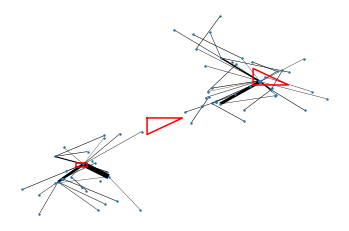

In [574]:
plotSim(Gsim, foodMap)

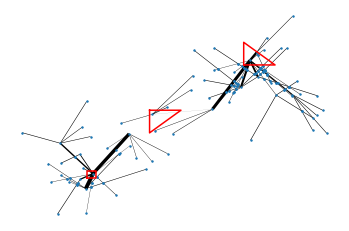

In [466]:
plotSim(Gsim, foodMap)

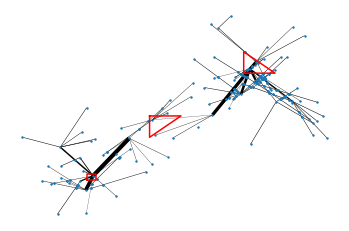

In [469]:
plotSim(Gsim, foodMap)

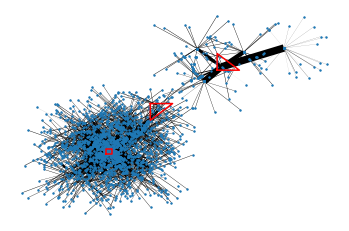

In [568]:
plotSim(Gsim, foodMap)

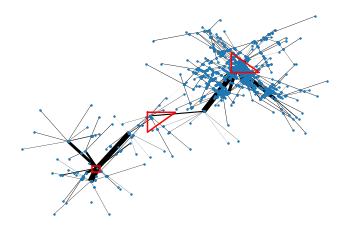

In [473]:
plotSim(Gsim, foodMap)

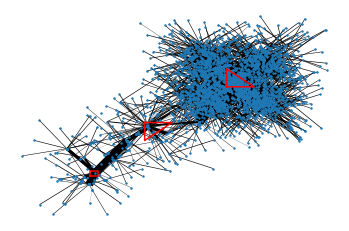

In [486]:
plotSim(Gsim, foodMap)